In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import sys
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'


from tensorflow import keras
from keras import ops
from keras import layers


from PIL import Image
import matplotlib.pyplot as plt

from keras import utils, models
from keras.layers import Rescaling
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from better_feature_extractor import extract_attribute_vector_advanced
import pandas as pd

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

from keras.layers import Rescaling

# Configuration
height = 128
width = 128
batch_size = 32

def load_labels(path_labels):
    """
    Load labels from a file.

    Args:
        path_labels (str): Path to the labels file.

    Returns:
        tuple: A tuple containing annotations and annotation names.
    """
    annotations = []
    try:
        with open(path_labels) as f:
            lines = f.readlines()
            num_images = int(lines[0].strip())
            annotation_names = lines[1].split()[1:]  # Skip 'filename'
            
            for line in lines[2:]:
                line = line.split()
                annotations.append(line)
    except FileNotFoundError:
        print(f"Error: The file {path_labels} was not found.")
        return None, None

    annotations = np.array(annotations)
    return annotations, annotation_names, num_images


def orthogonalize_vector(vector, existing_vectors):
    """
    Orthogonalize a vector with respect to existing vectors.
    
    Args:
        vector (np.ndarray): The vector to orthogonalize
        existing_vectors (list): List of existing orthogonal vectors
    
    Returns:
        np.ndarray: Orthogonalized vector
    """
    vector = np.squeeze(vector)  # Ensure vector is 1D for proper orthogonalization
    
    for existing_vec in existing_vectors:
        existing_vec = np.squeeze(existing_vec)
        # Gram-Schmidt orthogonalization
        projection = np.dot(vector, existing_vec) / np.dot(existing_vec, existing_vec)
        vector = vector - projection * existing_vec
        
    # Normalize the vector
    norm = np.linalg.norm(vector)
    if norm > 1e-10:  # Avoid division by near-zero
        vector = vector / norm
        
    return vector


def load_image(filename):
    """
    Load and preprocess an image.

    Args:
        filename (str): Path to the image file.

    Returns:
        tensor: Preprocessed image tensor.
    """
    # Handle tensorflow tensor inputs
    if isinstance(filename, tf.Tensor):
        filename = filename.numpy().decode('utf-8')
        
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [height, width])
        img = tf.cast(img, tf.float32) / 255.0  # Normalize here
        return img
    except tf.errors.InvalidArgumentError:
        print(f"Error loading image: {filename}")
        # Return a blank image as fallback
        return tf.zeros([height, width, 3], dtype=tf.float32)


def create_attribute_datasets(path_images, path_labels, attribute_names=None, max_samples=None):
    """
    Create datasets for all attributes or specified attributes.

    Args:
        path_images (str): Path to the images directory
        path_labels (str): Path to the labels file
        attribute_names (list, optional): Specific attributes to process
        max_samples (int, optional): Maximum number of samples per attribute

    Returns:
        dict: Dictionary mapping attribute names to (positive_dataset, negative_dataset) tuples
    """
    annotations, all_attribute_names, num_images = load_labels(path_labels)
    if annotations is None:
        print("Failed to load annotations. Exiting.")
        return None
    else:
        print(f"Loaded annotations for {num_images} images with {len(all_attribute_names)} attributes")
        
    # Use all attributes if none specified
    if attribute_names is None:
        attribute_names = all_attribute_names
        
    print("Attributes to process:", attribute_names)
    
    # Create datasets for each attribute
    attribute_datasets = {}
    
    for attr_name in tqdm(attribute_names, desc="Processing attributes"):
        try:
            # Find the index of this attribute in the annotations
            attr_index = all_attribute_names.index(attr_name) + 1  # +1 because first column is filename
            
            # Get filenames for positive and negative examples
            positive_filenames = []
            negative_filenames = []
            
            for row in annotations:
                if len(row) <= attr_index:
                    continue
                    
                file_path = os.path.join(path_images, row[0])
                if not os.path.exists(file_path):
                    continue
                    
                # Check attribute value (1 for positive, -1 for negative)
            
                if row[attr_index] == '1':
                    positive_filenames.append(file_path)
                elif row[attr_index] == '-1':
                    negative_filenames.append(file_path)
    
            
            # Limit dataset size if requested
            if max_samples and len(positive_filenames) > max_samples:
                positive_filenames = positive_filenames[:max_samples]
            if max_samples and len(negative_filenames) > max_samples:
                negative_filenames = negative_filenames[:max_samples]
                
            # Create TensorFlow datasets
            pos_dataset = tf.data.Dataset.from_tensor_slices(positive_filenames)
            pos_dataset = pos_dataset.map(
                lambda x: tf.py_function(load_image, [x], tf.float32), 
                num_parallel_calls=tf.data.AUTOTUNE
            )
            pos_dataset = pos_dataset.map(lambda x: tf.ensure_shape(x, [height, width, 3]))
            pos_dataset = pos_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            
            neg_dataset = tf.data.Dataset.from_tensor_slices(negative_filenames)
            neg_dataset = neg_dataset.map(
                lambda x: tf.py_function(load_image, [x], tf.float32), 
                num_parallel_calls=tf.data.AUTOTUNE
            )
            neg_dataset = neg_dataset.map(lambda x: tf.ensure_shape(x, [height, width, 3]))
            neg_dataset = neg_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            
            attribute_datasets[attr_name] = (pos_dataset, neg_dataset, len(positive_filenames), len(negative_filenames))
            
            print(f"Created datasets for {attr_name}: {len(positive_filenames)} positive, {len(negative_filenames)} negative examples")
            
        except ValueError as e:
            print(f"Error processing attribute {attr_name}: {e}")
            continue
            
    return attribute_datasets


def extract_attribute_vectors(
    vae_model, 
    attribute_datasets, 
    output_dir, 
    orthogonalize=True, 
    correlation_threshold=0.4,
    prioritized_attributes=None
):
    """
    Extract attribute vectors for all datasets with advanced techniques.

    Args:
        vae_model: The VAE model with encoder and decoder
        attribute_datasets: Dictionary of attribute datasets from create_attribute_datasets
        output_dir: Directory to save attribute vectors
        orthogonalize: Whether to orthogonalize vectors
        correlation_threshold: Maximum allowed correlation between attributes
        prioritized_attributes: List of attributes in priority order for orthogonalization

    Returns:
        dict: Dictionary of attribute vectors
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"Dataset includes {len(attribute_datasets)} attributes")
    print(f"Dataset size: {len(attribute_datasets)}")
    
    # Process attributes in priority order if specified
    if prioritized_attributes is None:
        # Use all attributes alphabetically
        attributes_to_process = sorted(attribute_datasets.keys())
    else:
        # Ensure all prioritized attributes exist in the datasets
        attributes_to_process = [attr for attr in prioritized_attributes if attr in attribute_datasets]
        # Add any remaining attributes
        attributes_to_process.extend([attr for attr in attribute_datasets if attr not in prioritized_attributes])
        
    print(f"Processing {len(attributes_to_process)} attributes")
    
    attribute_vectors = {}
    
    for attr_name in tqdm(attributes_to_process, desc="Extracting attribute vectors"):
        pos_dataset, neg_dataset, pos_count, neg_count = attribute_datasets[attr_name]
        
        if pos_count == 0 or neg_count == 0:
            print(f"Skipping {attr_name}: insufficient examples")
            continue
        
        # Process positive examples
        z_mean_positive = []
        for batch in tqdm(pos_dataset, desc=f"Processing positive {attr_name}", leave=False):
            batch_z_mean, _, _ = vae_model.encoder.predict(batch, verbose=0)
            z_mean_positive.append(batch_z_mean)
        
        # Process negative examples
        z_mean_negative = []
        for batch in tqdm(neg_dataset, desc=f"Processing negative {attr_name}", leave=False):
            batch_z_mean, _, _ = vae_model.encoder.predict(batch, verbose=0)
            z_mean_negative.append(batch_z_mean)
        
        # Concatenate batches
        if z_mean_positive and z_mean_negative:
            z_mean_positive = np.concatenate(z_mean_positive, axis=0)
            z_mean_negative = np.concatenate(z_mean_negative, axis=0)
            
            # Calculate mean vectors
            pos_mean = np.mean(z_mean_positive, axis=0)
            neg_mean = np.mean(z_mean_negative, axis=0)
            
            # Get variance information
            pos_var = np.var(z_mean_positive, axis=0)
            neg_var = np.var(z_mean_negative, axis=0)
            
            # Calculate the attribute vector with variance weighting
            # Focus on dimensions with higher variance between positive and negative
            var_ratio = np.maximum(pos_var, neg_var) / (np.minimum(pos_var, neg_var) + 1e-8)
            var_weight = np.clip(var_ratio - 1.0, 0, 10.0) / 10.0  # Scale to [0, 1]
            
            # Weighted attribute vector: give more weight to dimensions with higher variance contrast
            attr_vector = (pos_mean - neg_mean) * (var_weight + 0.5)  # Ensure base weight of 0.5 minimum
            
            # Normalize the vector
            attr_vector = attr_vector / (np.linalg.norm(attr_vector) + 1e-8)
            
            # Orthogonalize if required
            if orthogonalize and attribute_vectors:
                existing_vectors = list(attribute_vectors.values())
                original_vector = attr_vector.copy()
                attr_vector = orthogonalize_vector(attr_vector, existing_vectors)
                
                # Check if orthogonalization preserved enough of the original vector
                similarity = np.dot(original_vector, attr_vector)
                if similarity < 0.7:  # Less than 70% similar to original
                    print(f"Warning: Orthogonalization significantly changed {attr_name} vector (similarity: {similarity:.2f})")
            
            # Check correlation with existing vectors
            if attribute_vectors:
                for existing_attr, existing_vec in attribute_vectors.items():
                    correlation = np.dot(attr_vector, existing_vec)
                    if abs(correlation) > correlation_threshold:
                        print(f"Warning: {attr_name} vector has high correlation ({correlation:.2f}) with {existing_attr}")
            
            # Save the attribute vector
            attribute_vectors[attr_name] = attr_vector
            np.save(os.path.join(output_dir, f"{attr_name}_vector.npy"), attr_vector)
            
            print(f"Extracted vector for {attr_name}")
        else:
            print(f"Skipping {attr_name}: failed to extract features")
    
    # Create a summary file
    with open(os.path.join(output_dir, "attribute_summary.txt"), "w") as f:
        f.write(f"Total attributes extracted: {len(attribute_vectors)}\n\n")
        for attr_name in attribute_vectors:
            f.write(f"{attr_name}\n")
    
    return attribute_vectors


def manipulate_image(image_path, vae_model, attribute_vector, strength=1.0, output_path=None, method='additive'):
    """
    Manipulate an image using an attribute vector.

    Args:
        image_path: Path to the input image
        vae_model: Tuple of (encoder, decoder) models
        attribute_vector: The attribute vector to apply
        strength: Strength of manipulation
        output_path: Path to save the result
        method: 'additive' or 'interpolative'

    Returns:
        numpy.ndarray: The manipulated image
    """
    encoder, decoder = vae_model
    
    # Load and preprocess the image
    img = Image.open(image_path).resize((height, width))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Encode the image
    z_mean, z_log_var, z = encoder.predict(img_array, verbose=0)
    
    # Apply the attribute vector
    if method == 'additive':
        z_modified = z + attribute_vector * strength
    elif method == 'interpolative':
        attribute_direction = attribute_vector / np.linalg.norm(attribute_vector)
        current_projection = np.dot(z[0], attribute_direction)
        target_projection = current_projection + strength
        z_modified = z + (target_projection - current_projection) * attribute_direction
    else:
        raise ValueError("Method must be 'additive' or 'interpolative'")
    
    # Decode to get the manipulated image
    manipulated_img = decoder.predict(z_modified, verbose=0)
    
    # Convert to displayable format
    manipulated_img = np.clip(manipulated_img[0], 0, 1)
    
    # Save if output path is provided
    if output_path:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array[0])
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(manipulated_img)
        plt.title(f"Manipulated (strength={strength})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()
    
    return manipulated_img


def analyze_attribute_vectors(attribute_vectors_dir, output_dir):
    """
    Analyze attribute vectors for correlations and create visualizations.

    Args:
        attribute_vectors_dir: Directory containing attribute vector .npy files
        output_dir: Directory to save analysis results
    """
    import seaborn as sns
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Load all attribute vectors
    vectors = {}
    for filename in os.listdir(attribute_vectors_dir):
        if filename.endswith("_vector.npy"):
            attr_name = filename.replace("_vector.npy", "")
            vectors[attr_name] = np.load(os.path.join(attribute_vectors_dir, filename))
    
    if not vectors:
        print("No attribute vectors found for analysis")
        return
    
    # Calculate correlation matrix
    attrs = sorted(vectors.keys())
    corr_matrix = np.zeros((len(attrs), len(attrs)))
    
    for i, attr1 in enumerate(attrs):
        for j, attr2 in enumerate(attrs):
            corr_matrix[i, j] = np.dot(vectors[attr1], vectors[attr2])
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", xticklabels=attrs, yticklabels=attrs, cmap="coolwarm")
    plt.title("Attribute Vector Correlations")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "attribute_correlations.png"))
    
    # Find highly correlated pairs
    high_correlations = []
    for i, attr1 in enumerate(attrs):
        for j, attr2 in enumerate(attrs):
            if i < j and abs(corr_matrix[i, j]) > 0.5:
                high_correlations.append((attr1, attr2, corr_matrix[i, j]))
    
    # Save correlation report
    with open(os.path.join(output_dir, "correlation_report.txt"), "w") as f:
        f.write("Attribute Vector Correlation Analysis\n")
        f.write("====================================\n\n")
        f.write(f"Total attributes analyzed: {len(attrs)}\n\n")
        
        f.write("Highly correlated attribute pairs (|correlation| > 0.5):\n")
        for attr1, attr2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
            f.write(f"{attr1} - {attr2}: {corr:.4f}\n")


def run_attribute_extraction_pipeline(vae_model, attr_file_path, img_dir, output_dir, 
                                      max_samples=1000, priority_attributes=None, test_image=None):
    """
    Run the complete attribute extraction pipeline.

    Args:
        vae_model: Tuple of (encoder, decoder) models
        attr_file_path: Path to attribute file
        img_dir: Path to image directory
        output_dir: Base output directory
        max_samples: Maximum samples per attribute
        priority_attributes: List of attributes to prioritize
        test_image: Optional path to test image for visualization
    """
    print("Starting attribute extraction pipeline...")
    
    # Create output directories
    vectors_dir = os.path.join(output_dir, "attribute_vectors")
    analysis_dir = os.path.join(output_dir, "analysis")
    test_dir = os.path.join(output_dir, "test_manipulations")
    
    os.makedirs(vectors_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Create datasets
    print("\nCreating datasets for each attribute...")
    attribute_datasets = create_attribute_datasets(img_dir, attr_file_path) 
                                                
    
    if not attribute_datasets:
        print("Failed to create attribute datasets. Exiting.")
        return
    
    # Extract attribute vectors
    print("\nExtracting attribute vectors...")
    attribute_vectors = extract_attribute_vectors(
        vae_model,
        attribute_datasets,
        vectors_dir,
        orthogonalize=True,
        correlation_threshold=0.3,
        prioritized_attributes=priority_attributes
    )
    
    # Analyze attribute vectors
    print("\nAnalyzing attribute vectors...")
    analyze_attribute_vectors(vectors_dir, analysis_dir)
    
    # Test attribute vectors if test image provided
    if test_image and os.path.exists(test_image):
        print("\nTesting attribute vectors on sample image...")
        for attr, vector in attribute_vectors.items():
            manipulate_image(
                test_image,
                vae_model,
                vector,
                strength=2.0,
                output_path=os.path.join(test_dir, f"{attr}_manipulation.png")
            )
            
            # Also test negative manipulation
            manipulate_image(
                test_image,
                vae_model,
                -vector,
                strength=2.0,
                output_path=os.path.join(test_dir, f"{attr}_negative_manipulation.png")
            )
    
    print("\nAttribute extraction pipeline complete!")
    print(f"Results saved to {output_dir}")

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a face."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(280602)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon
    
def create_encoder(input_shape=(128, 128, 3), latent_dim=512):
    inputs = keras.Input(shape=input_shape)
    
    
    x = layers.Conv2D(64, (4,4), activation='leaky_relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(256, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(512, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    
    # Add dense layers before final latent space
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    return keras.Model(inputs, [z_mean, z_log_var, z], name='improved_encoder')


def create_decoder(latent_dim=512):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    x = layers.Dense(8*8*512, activation='leaky_relu')(latent_inputs)
    x = layers.Reshape((8, 8, 512))(x)
    
    x = layers.Conv2DTranspose(256, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(128, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(64, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(32, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2DTranspose(3, (4,4), activation='sigmoid', padding='same')(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name='improved_decoder')


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.lambda_reconstruction = 0.1
        self.lambda_perceptual = 0.1
        
        # Initialize VGG19 for feature extraction (use pre-trained weights)
        vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
        
        # Choose intermediate layers for feature comparison
        self.feature_layers = [
            'block1_conv2',  # Low-level features
            'block2_conv2',  # Mid-level features
            'block3_conv2',  # Higher-level features
            'block4_conv2'   # Very high-level features
        ]
        
        # Create a model that outputs features from these layers
        self.feature_extractor = keras.Model(
            inputs=vgg.input, 
            outputs=[vgg.get_layer(name).output for name in self.feature_layers]
        )
        
        # Freeze the VGG19 weights
        self.feature_extractor.trainable = False
        
        # Tracking metrics
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.perceptual_loss_tracker = keras.metrics.Mean(name='perceptual_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
        
        # Add validation metrics
        self.val_total_loss_tracker = keras.metrics.Mean(name='val_total_loss')
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(name='val_reconstruction_loss')
        self.val_perceptual_loss_tracker = keras.metrics.Mean(name='val_perceptual_loss')
        self.val_kl_loss_tracker = keras.metrics.Mean(name='val_kl_loss')
    
    def call(self, inputs):
        # Implement the forward pass
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.perceptual_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_perceptual_loss_tracker,
            self.val_kl_loss_tracker
        ]
    
    def compute_perceptual_loss(self, original, reconstructed):
        # Preprocess images for VGG19 (ensure 3 channels and correct scaling)
        original_processed = preprocess_input(original * 255.0)
        reconstructed_processed = preprocess_input(reconstructed * 255.0)
        
        # Extract features for original and reconstructed images
        original_features = self.feature_extractor(original_processed)
        reconstructed_features = self.feature_extractor(reconstructed_processed)
    
        
        # Compute perceptual loss as mean squared error between features
        perceptual_loss = 0
        for orig_feat, recon_feat in zip(original_features, reconstructed_features):
            perceptual_loss += ops.mean(ops.square(orig_feat - recon_feat))

        
        # Normalize by the number of feature layers
        perceptual_loss /= len(self.feature_layers)
        
        return perceptual_loss
    
    def compute_reconstruction_loss(self, original, reconstructed):
        
        reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(original, reconstructed),
                    axis=(1,2)
                )
            )
        
        return reconstruction_loss
   
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder forward pass
            z_mean, z_log_var, z = self.encoder(data)
            
            # Decoder reconstruction
            reconstruction = self.decoder(z)
            
            # Compute KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            
            
            # Compute perceptual loss using VGG19 features
            perceptual_loss = self.compute_perceptual_loss(data, reconstruction) * self.lambda_perceptual
            
            reconstruction_loss = self.compute_reconstruction_loss(data, reconstruction) * self.lambda_reconstruction
            
            # Total loss combines reconstruction losses and KL divergence
            total_loss = kl_loss + (perceptual_loss + reconstruction_loss)/2
        
        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.perceptual_loss_tracker.update_state(perceptual_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "perceptual_loss": self.perceptual_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Encoder forward pass
        z_mean, z_log_var, z = self.encoder(data)
        
        # Decoder reconstruction
        reconstruction = self.decoder(z)
        
        # Compute KL divergence loss
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        
        # Compute perceptual loss using VGG19 features
        perceptual_loss = self.compute_perceptual_loss(data, reconstruction) * self.lambda_perceptual
        
        reconstruction_loss = self.compute_reconstruction_loss(data, reconstruction) * self.lambda_reconstruction
        
        # Total loss combines perceptual loss and KL divergence
        total_loss = kl_loss + (reconstruction_loss + perceptual_loss)/2
        
        # Update validation metrics
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_perceptual_loss_tracker.update_state(perceptual_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.val_total_loss_tracker.result(),
            "perceptual_loss": self.val_perceptual_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result()
        }

2025-06-07 06:13:46.201829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 06:13:46.240069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 06:13:46.258310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 06:13:46.339923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
attr_file_path = "./Dataset/list_attr_celeba.txt"  # Path to attribute file
img_dir = "./Dataset/all_images/img_align_celeba" 

encoder = create_encoder(latent_dim=512)
decoder = create_decoder(latent_dim=512)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
vae.load_weights('./results_encode_decode/20/vae_weights.weights.h5')
vae.summary()

In [3]:
from feature_extractor import encode_whole_dataset

encodings = encode_whole_dataset(vae, img_dir)


I0000 00:00:1749276844.137581 3885219 service.cc:146] XLA service 0x7f5df800a250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749276844.137649 3885219 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
I0000 00:00:1749276844.137654 3885219 service.cc:154]   StreamExecutor device (1): NVIDIA A40, Compute Capability 8.6
I0000 00:00:1749276844.137659 3885219 service.cc:154]   StreamExecutor device (2): NVIDIA A40, Compute Capability 8.6
2025-06-07 06:14:04.578694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-07 06:14:04.767306: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91001


  32/6332 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step  

I0000 00:00:1749276851.455094 3885219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6332/6332 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step


In [ ]:
from feature_extractor import load_labels, get_attribute_index

def extract_attribute_vectors_from_encodings(encodings, annotations_file):
    """
    Extract the attribute vectors from the encodings.

    Args:
        model: The model to use for encoding.
        encodings (np.ndarray): Encoded images.
        annotations_file (str): Path to the annotations file.

    Returns:
        dict: Dictionary of attribute vectors.
    """
    annotations, annotations_name = load_labels(annotations_file)
    
    attribute_vectors = {}
    for attribute_name in annotations_name:
        attribute_index = get_attribute_index(annotations_name, attribute_name)
        
        attribute_vector = []
        for i in range(len(annotations)):
            if annotations[i][attribute_index] == '1':
                attribute_vector.append(encodings[i])
                
        without_attribute_vector = []
        for i in range(len(annotations)):
            if annotations[i][attribute_index] == '-1':
                without_attribute_vector.append(encodings[i])
                
        mean_encoded_with_attribute = np.mean(attribute_vector, axis=0)
        mean_encoded_without_attribute = np.mean(without_attribute_vector, axis=0)
        attribute_vector = mean_encoded_with_attribute - mean_encoded_without_attribute
        
        attribute_vectors[attribute_name] = attribute_vector
        
    return attribute_vectors

attribute_vectors = extract_attribute_vectors_from_encodings(
    encodings,
    attr_file_path
)

In [5]:
df = pd.DataFrame(attribute_vectors)
#remove the first column
df = df.iloc[:, 1:]


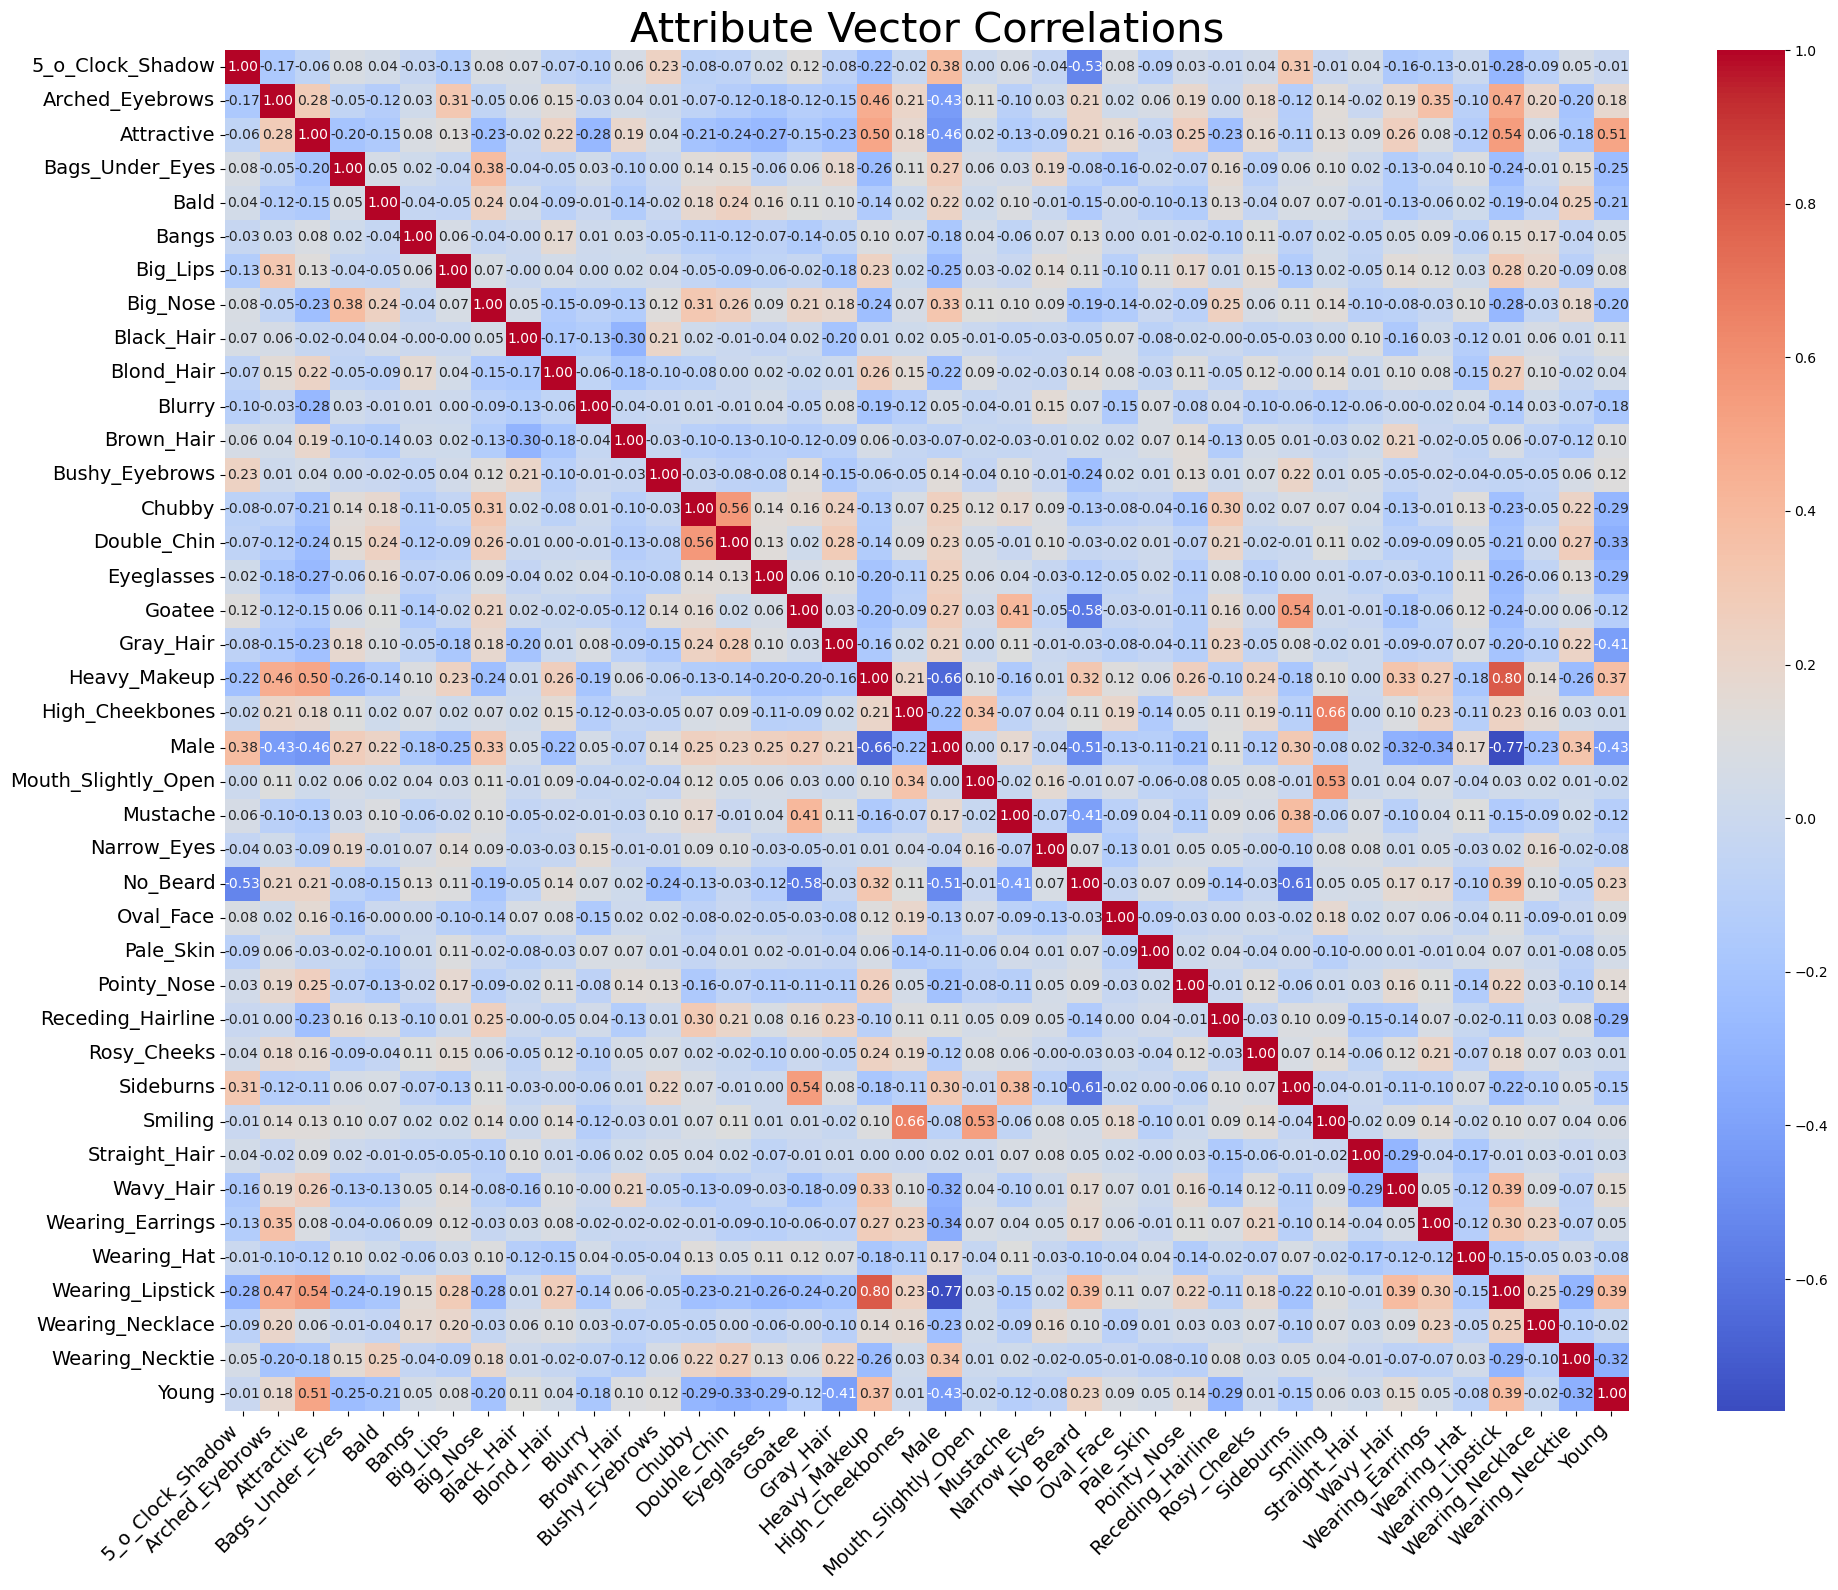

In [24]:
import seaborn as sns
# Plot correlation matrix in reverse coolwarm with larger annotation font size and axis labels
plt.figure(figsize=(20, 16))
sns.heatmap(
    df.corr(),
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    xticklabels=df.columns,
    yticklabels=df.columns,
    cmap="coolwarm"
)
plt.title("Attribute Vector Correlations", fontsize=30)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("results_encode_decode/20/attribute_analysis/analysis/attribute_correlations.png")
plt.show()
# Find highly correlated pairs

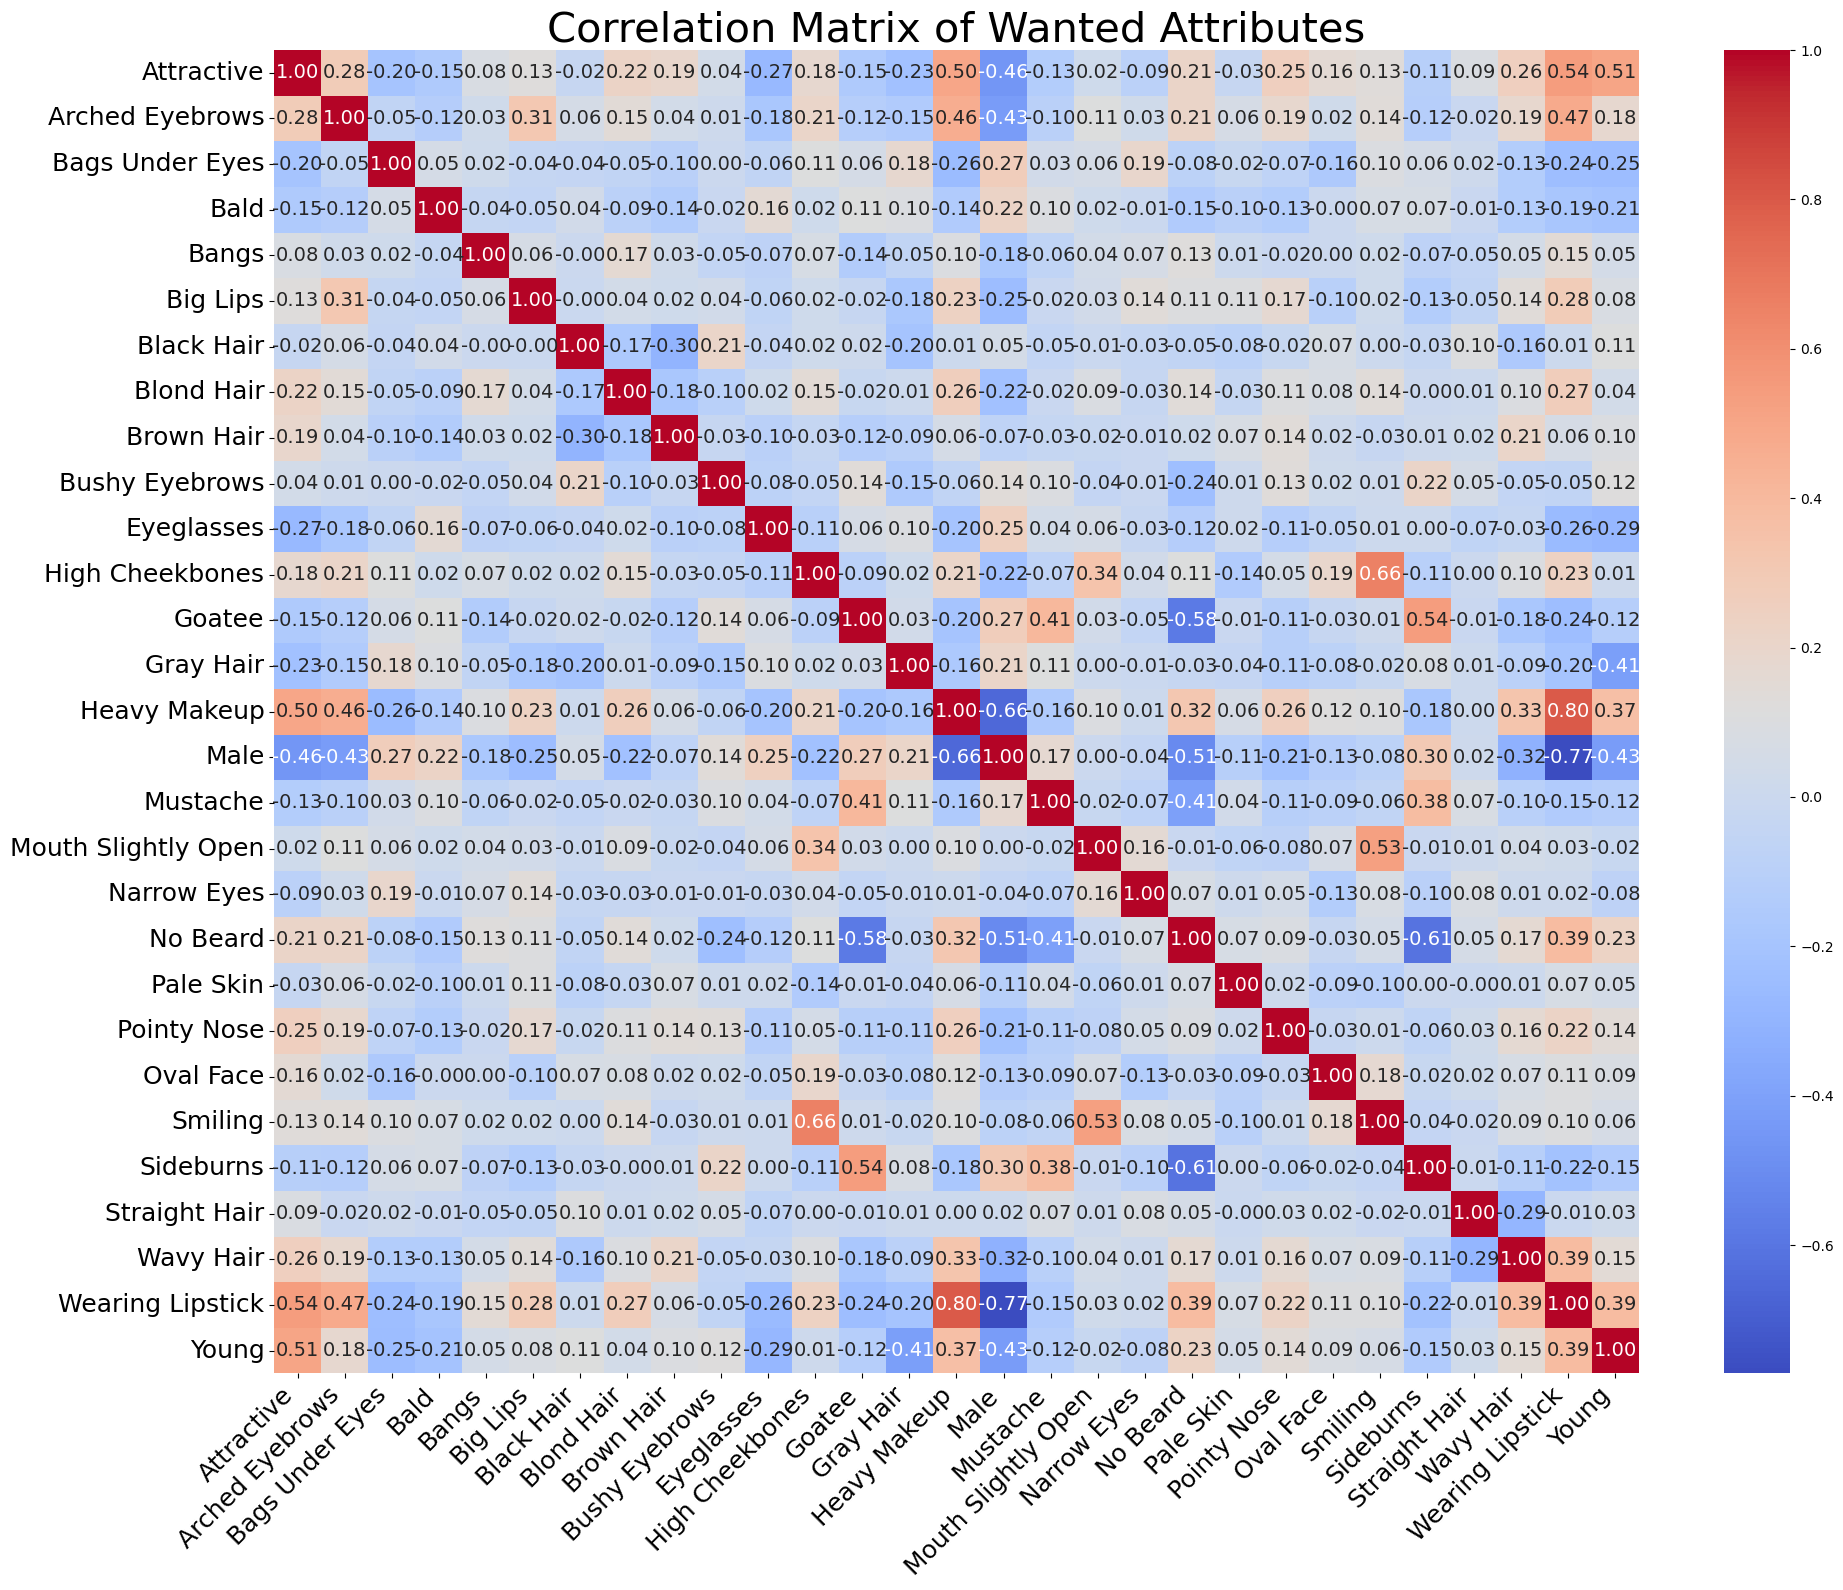

In [27]:
import seaborn as sns
wanted_attributes = [
    "Attractive", "Arched Eyebrows", "Bags Under Eyes", "Bald", "Bangs", "Big Lips", "Black Hair",
    "Blond Hair", "Brown Hair", "Bushy Eyebrows", "Eyeglasses", "High Cheekbones",
    "Goatee", "Gray Hair", "Heavy Makeup", "Male", "Mustache", "Mouth Slightly Open",
    "Narrow Eyes", "No Beard", "Pale Skin", "Pointy Nose", "Oval Face",
    "Smiling","Sideburns", "Straight Hair", "Wavy Hair", "Wearing Lipstick", 
    "Young"
]

# Convert attribute names to match DataFrame columns (replace spaces with underscores)
wanted_attributes_underscored = [attr.replace(" ", "_") for attr in wanted_attributes]

# Filter the dataframe to only wanted attributes
df_wanted = df[wanted_attributes_underscored]

# Plot correlation matrix for wanted attributes with larger annotation font size
plt.figure(figsize=(20, 16))
sns.heatmap(
    df_wanted.corr(),
    annot=True,
    fmt=".2f",
    annot_kws={"size": 14},
    xticklabels=wanted_attributes,
    yticklabels=wanted_attributes,
    cmap="coolwarm"
)
plt.title("Correlation Matrix of Wanted Attributes", fontsize=30)
plt.xticks(fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("results_encode_decode/20/attribute_analysis/analysis/attribute_correlations_small.png")
plt.show()


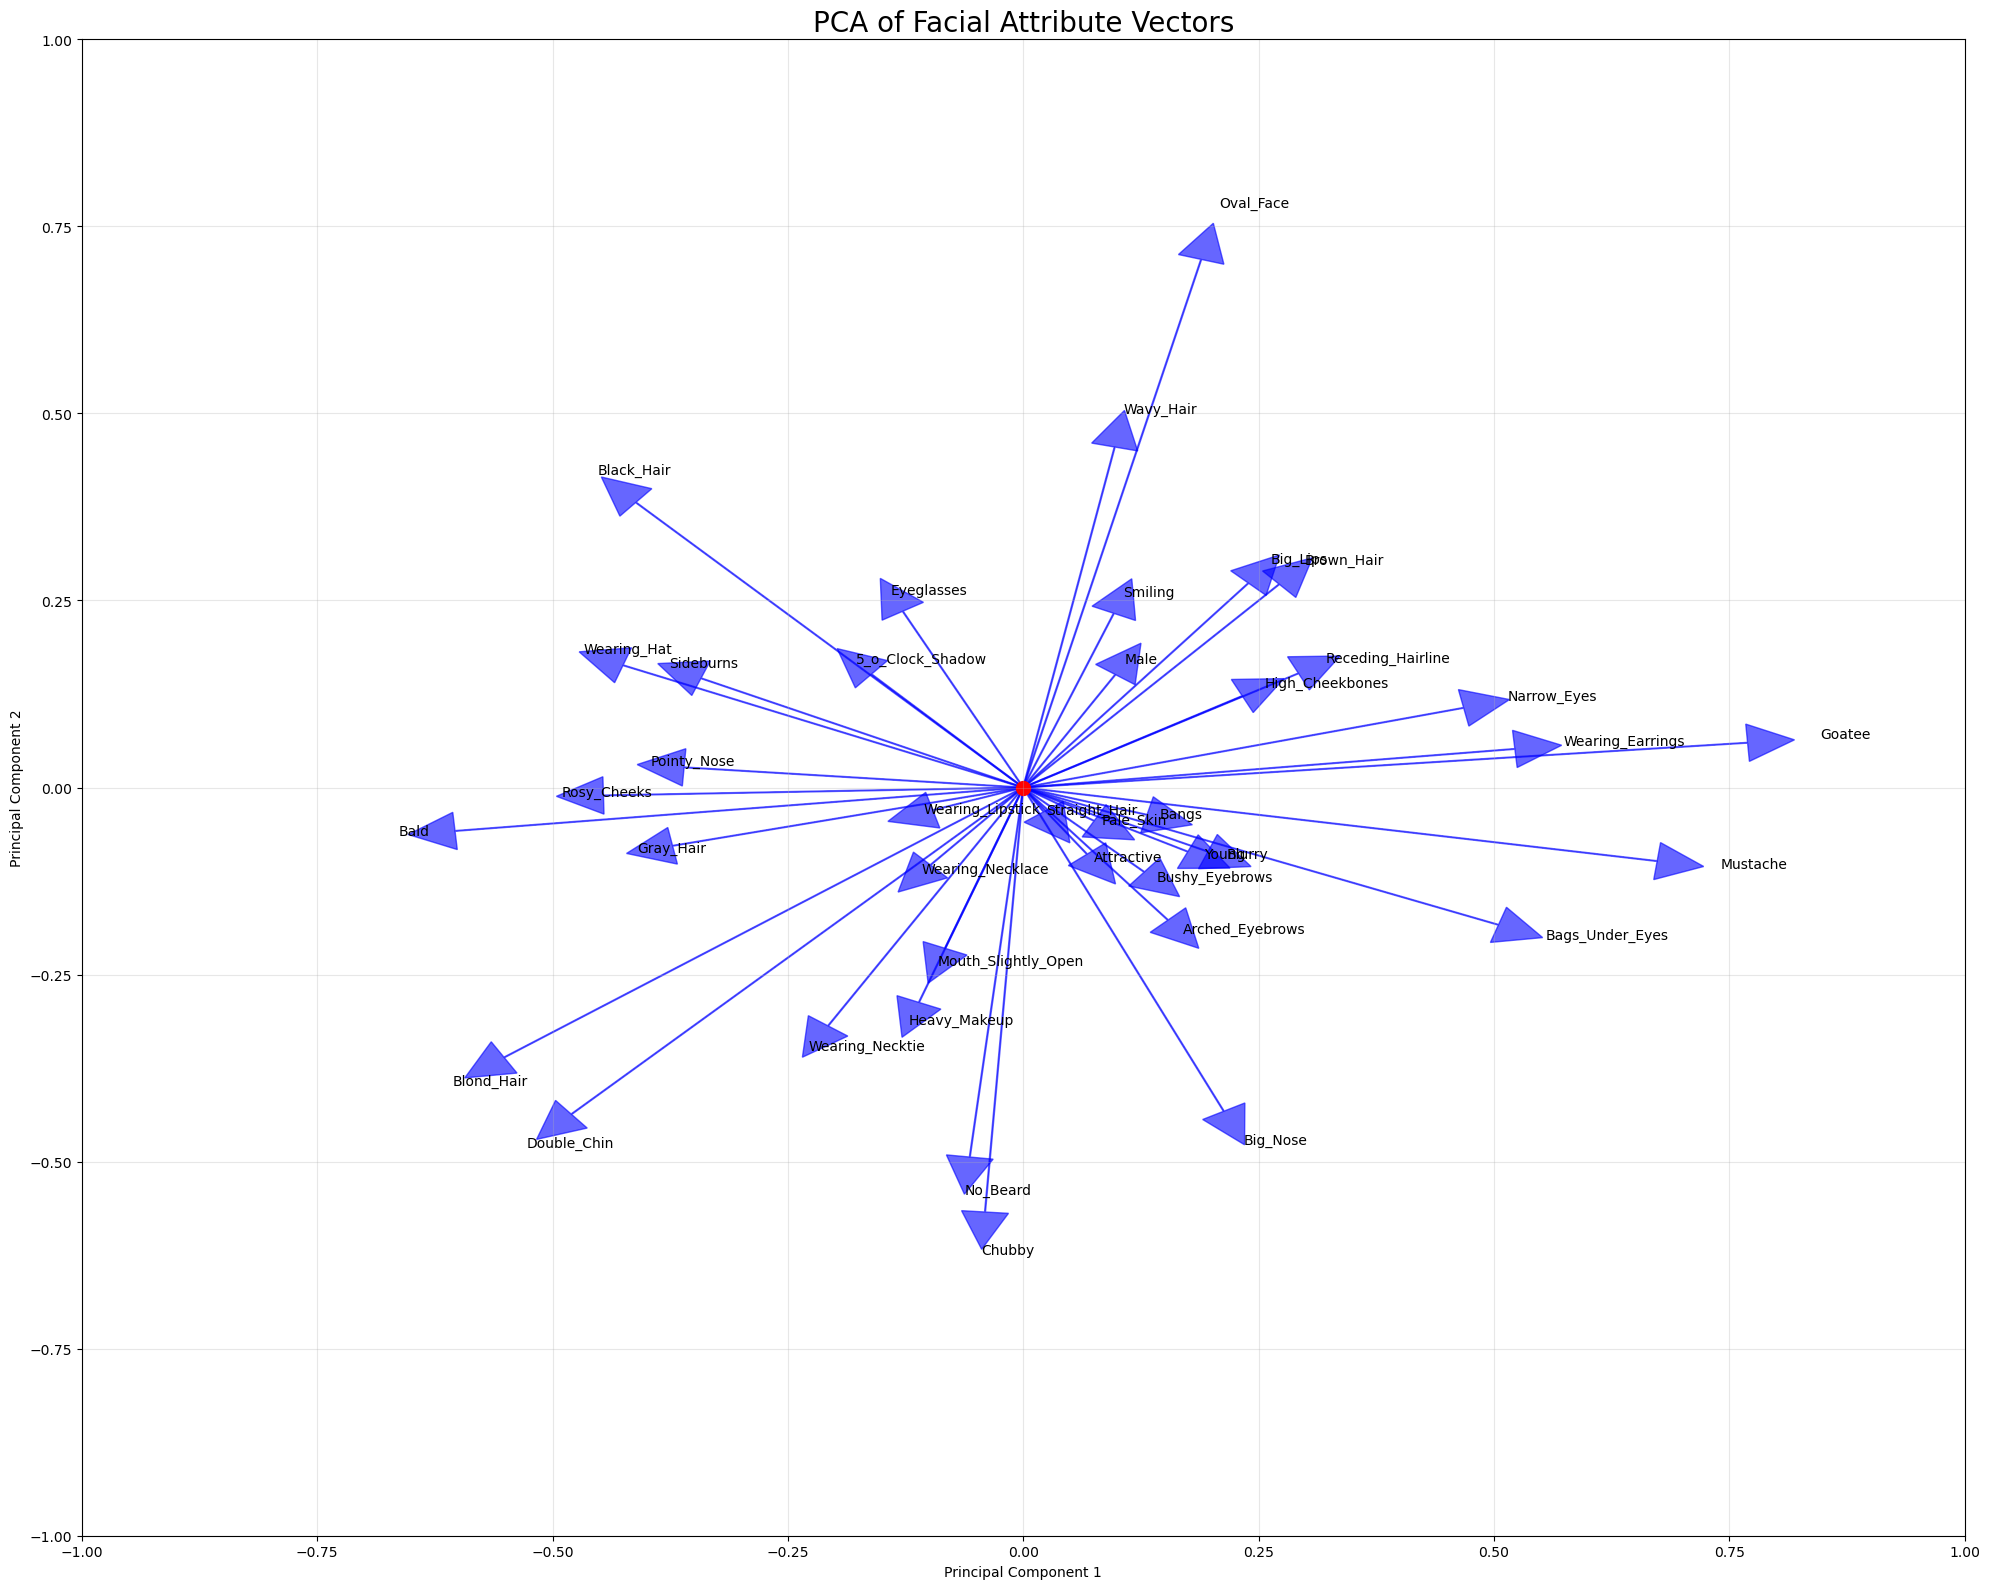

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
attribute_vectors_2d = pca.fit_transform(df.values)

# Create a figure for plotting
plt.figure(figsize=(20, 16))

# Plot the arrows for each attribute direction
for i, attribute in enumerate(df.columns):
    # Plot an arrow for each attribute
    plt.arrow(0, 0, attribute_vectors_2d[i, 0] * 20, attribute_vectors_2d[i, 1] * 20, 
              head_width=0.05, head_length=0.05, fc='blue', ec='blue', alpha=0.6)
    
    # Label each arrow with the attribute name
    plt.text(attribute_vectors_2d[i, 0] * 20 * 1.1, attribute_vectors_2d[i, 1] * 20 * 1.1, 
             attribute, fontsize=10)

# Add a small red point at the origin
plt.scatter(0, 0, color='red', s=100)

# Set plot title and labels
plt.title('PCA of Facial Attribute Vectors', fontsize=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add grid
plt.grid(alpha=0.3)

# Adjust axis limits to make sure all arrows are visible
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.tight_layout()
plt.savefig("results_encode_decode/20/attribute_analysis/analysis/attribute_vectors_pca.png", dpi=300)
plt.show()


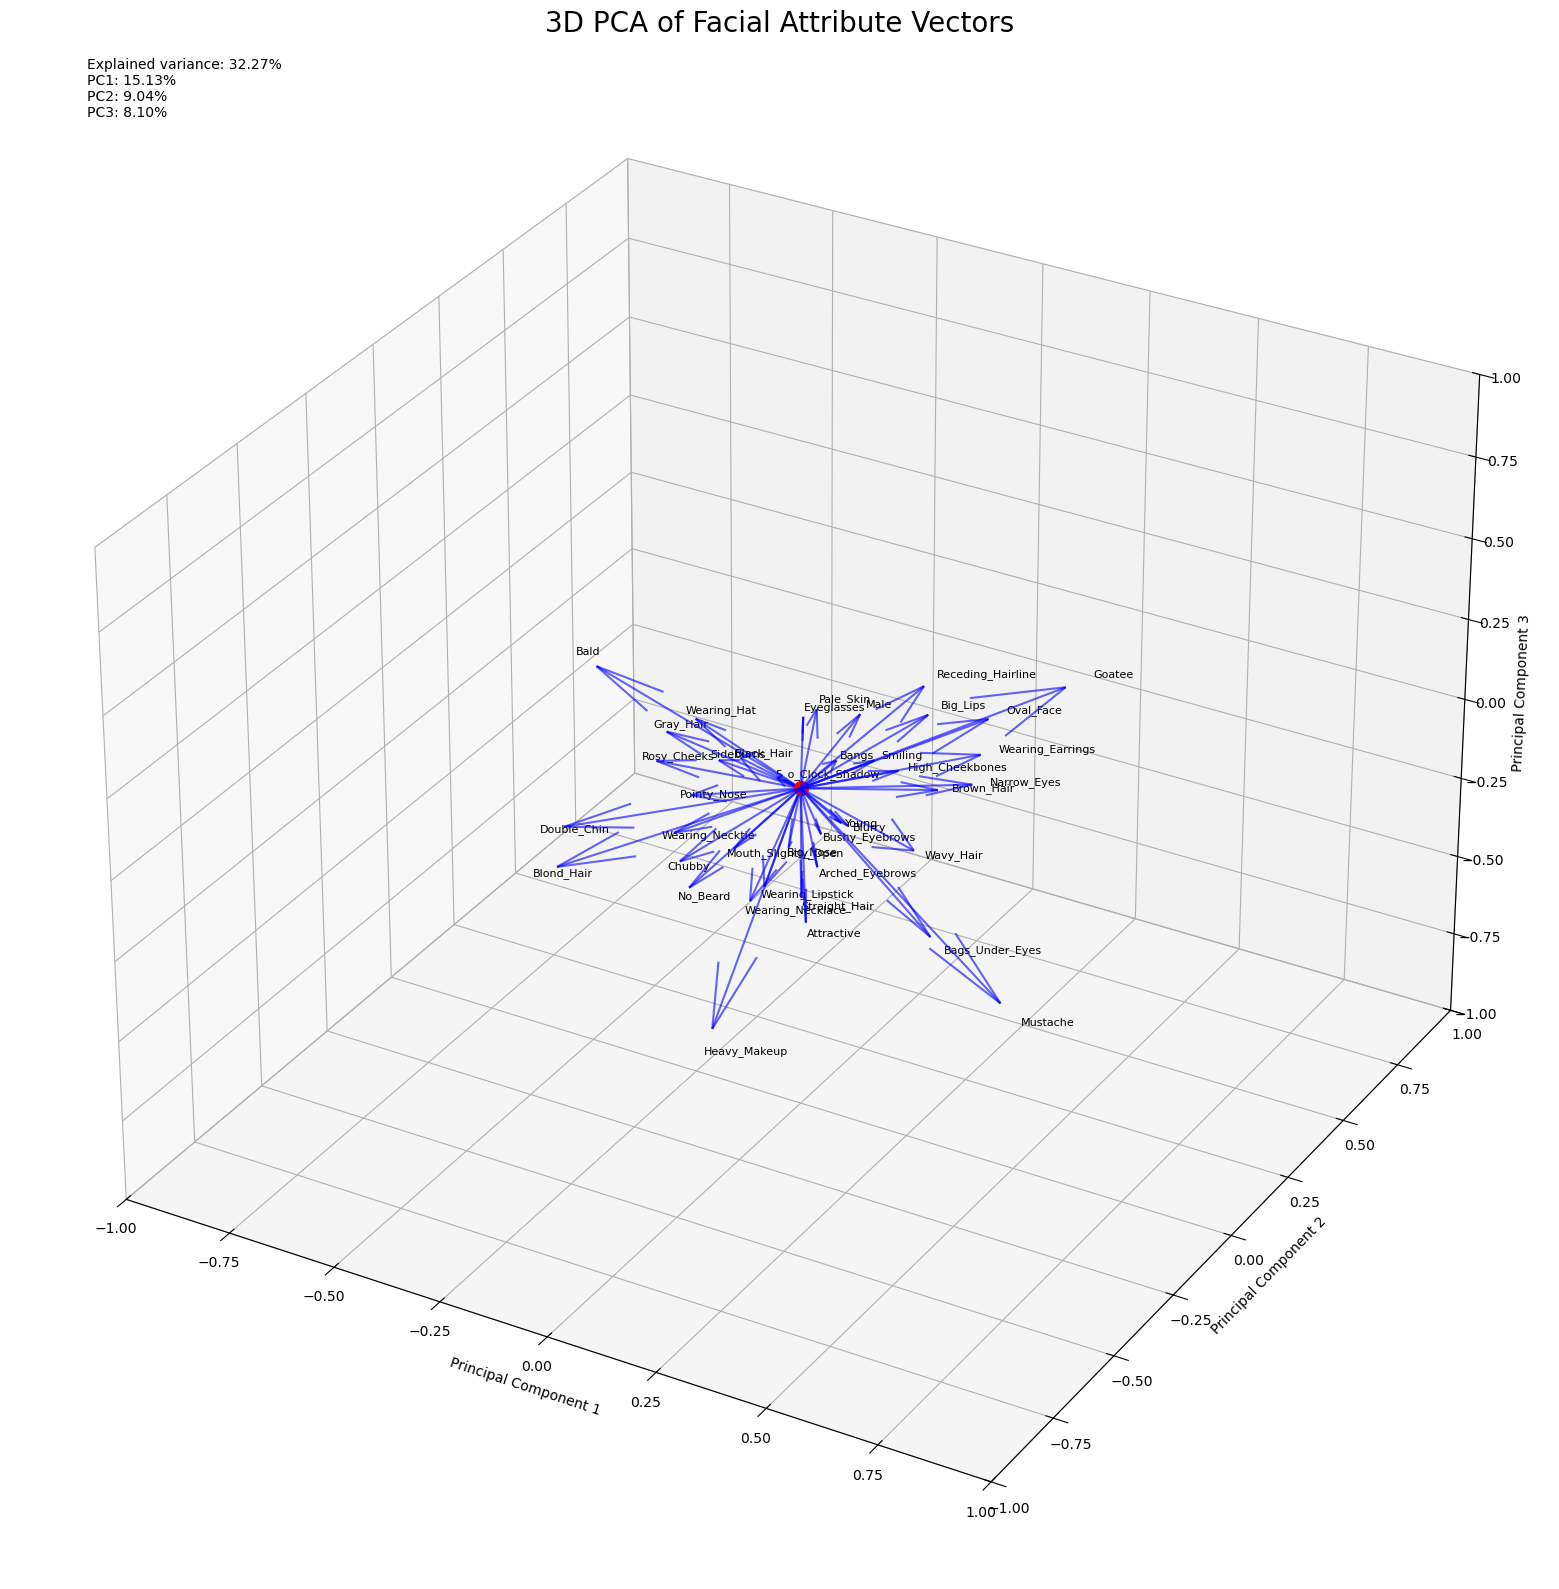

In [9]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce to 3 dimensions
pca_3d = PCA(n_components=3)
attribute_vectors_3d = pca_3d.fit_transform(df.values)

# Create a figure for plotting
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the arrows for each attribute direction
for i, attribute in enumerate(df.columns):
    # Plot an arrow for each attribute
    ax.quiver(0, 0, 0, 
              attribute_vectors_3d[i, 0] * 15, 
              attribute_vectors_3d[i, 1] * 15, 
              attribute_vectors_3d[i, 2] * 15,
              color='blue', alpha=0.6)
    
    # Label each arrow with the attribute name
    ax.text(attribute_vectors_3d[i, 0] * 15 * 1.1, 
            attribute_vectors_3d[i, 1] * 15 * 1.1, 
            attribute_vectors_3d[i, 2] * 15 * 1.1, 
            attribute, fontsize=8)

# Add a small red point at the origin
ax.scatter(0, 0, 0, color='red', s=100)

# Set plot title and labels
ax.set_title('3D PCA of Facial Attribute Vectors', fontsize=20)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add grid
ax.grid(alpha=0.3)

# Adjust axis limits to make sure all arrows are visible
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Add variance explained ratio
explained_variance = pca_3d.explained_variance_ratio_
ax.text2D(0.05, 0.95, f"Explained variance: {sum(explained_variance)*100:.2f}%\nPC1: {explained_variance[0]*100:.2f}%\nPC2: {explained_variance[1]*100:.2f}%\nPC3: {explained_variance[2]*100:.2f}%", 
          transform=ax.transAxes)

plt.tight_layout()
plt.savefig("results_encode_decode/20/attribute_analysis/analysis/attribute_vectors_pca_3d.png", dpi=300)
plt.show()
fig.canvas.manager.show()

In [13]:
#save df to csv
df.to_csv("results_encode_decode/20/attribute_analysis/analysis/attribute_vectors.csv", index=False)

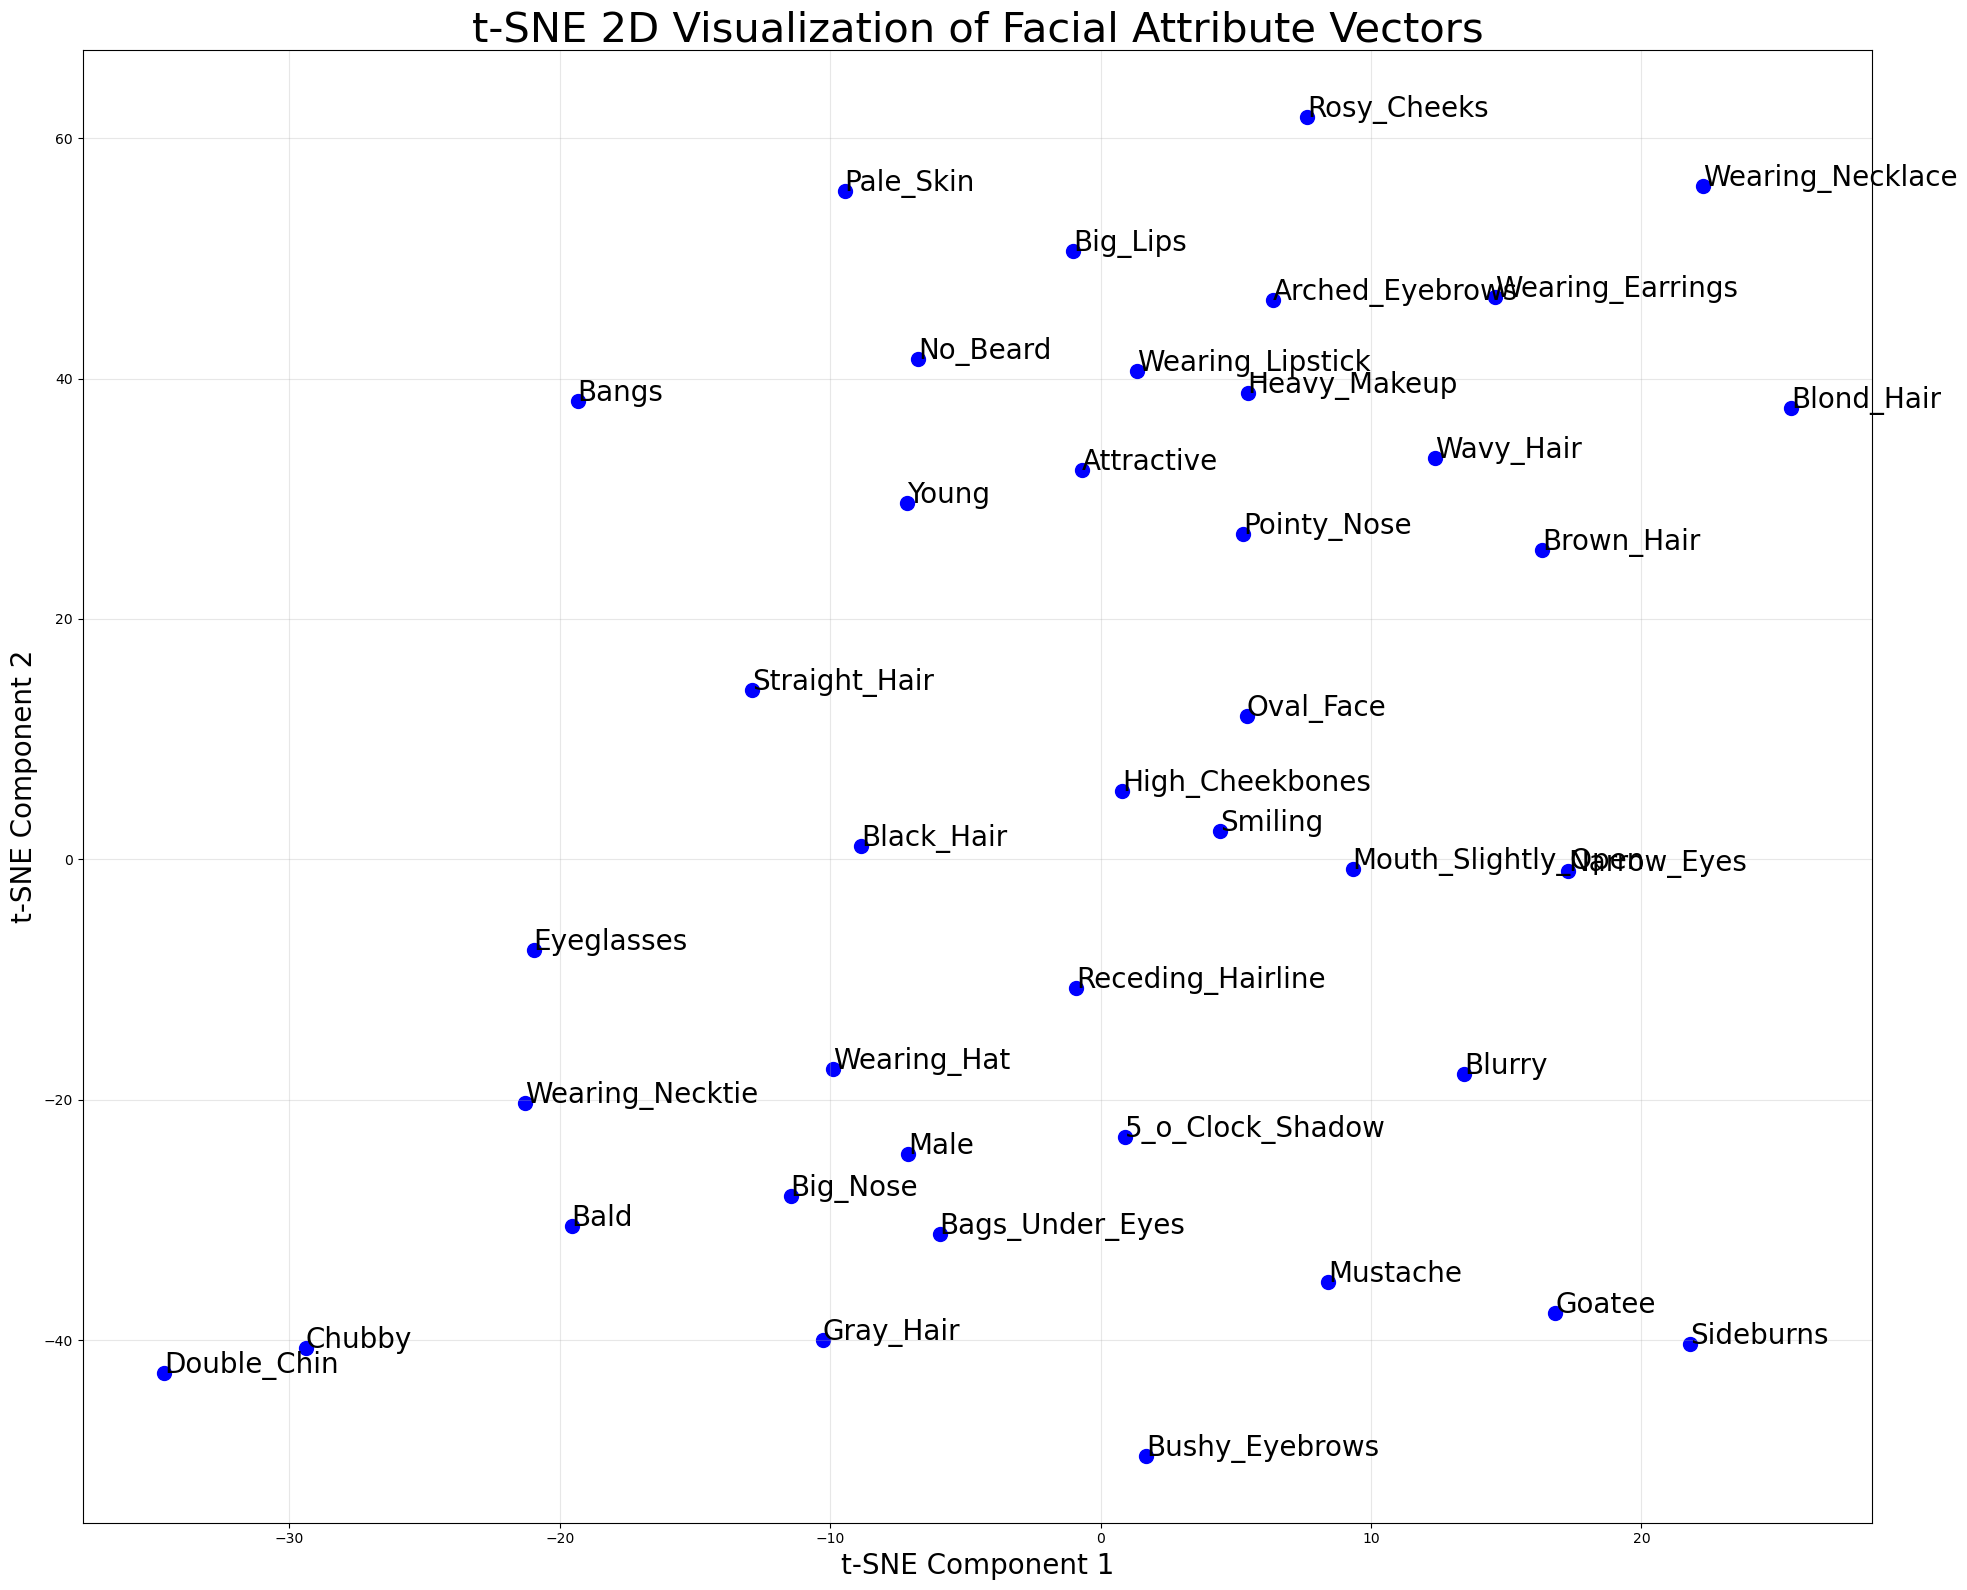

In [14]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
attribute_vectors_tsne = tsne.fit_transform(df.values.T)

plt.figure(figsize=(20, 16))

# Plot the arrows for each attribute direction
for i, attribute in enumerate(df.columns):
    plt.scatter(attribute_vectors_tsne[i, 0], attribute_vectors_tsne[i, 1], color='blue', s=100)
    plt.text(attribute_vectors_tsne[i, 0], attribute_vectors_tsne[i, 1], attribute, fontsize=20)

plt.title('t-SNE 2D Visualization of Facial Attribute Vectors', fontsize=30)
plt.xlabel('t-SNE Component 1', fontsize=20)
plt.ylabel('t-SNE Component 2', fontsize=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("results_encode_decode/20/attribute_analysis/analysis/attribute_vectors_tsne.png", dpi=300)
plt.show()

In [ ]:
import umap

# Apply UMAP to reduce to 2 dimensions
umap_2d = umap.UMAP(n_components=2, random_state=42)
attribute_vectors_umap = umap_2d.fit_transform(df.values.T)

plt.figure(figsize=(20, 16))

# Plot the points for each attribute direction
for i, attribute in enumerate(df.columns):
    plt.scatter(attribute_vectors_umap[i, 0], attribute_vectors_umap[i, 1], color='blue', s=100)
    plt.text(attribute_vectors_umap[i, 0], attribute_vectors_umap[i, 1], attribute, fontsize=20)

plt.title('UMAP 2D Visualization of Facial Attribute Vectors', fontsize=30)
plt.xlabel('UMAP Component 1', fontsize=20)
plt.ylabel('UMAP Component 2', fontsize=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("results_encode_decode/20/attribute_analysis/analysis/attribute_vectors_umap.png", dpi=300)
plt.show()